/tmp/ipython-input-167/686772998.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


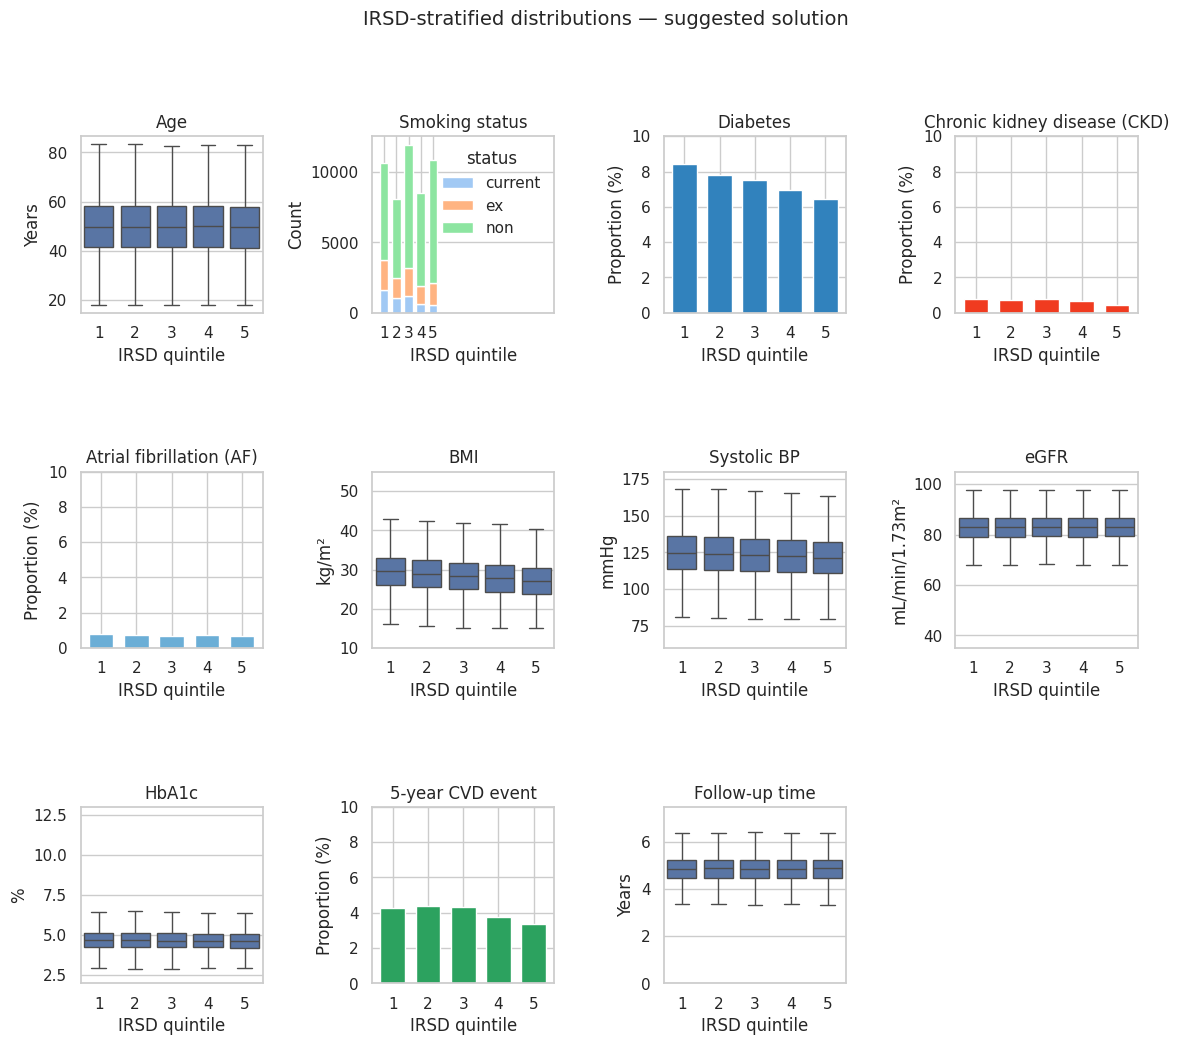

In [2]:
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

import copy

RNG_SEED = 42

def seed_all(seed: int = RNG_SEED) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

seed_all()

url = "https://ndownloader.figshare.com/files/62102364"
Data001 = pd.read_csv(url)
Data001 = Data001.drop(columns=["Unnamed: 0"], errors="ignore")

Data001.head()

df = copy.copy(Data001)

sns.set(style="whitegrid")

REQUIRED_COLUMNS = {
    'IRSD_quintile', 'Age', 'smoking_status', 'BMI', 'SBP', 'HbA1c', 'eGFR',
    'diabetes', 'CKD', 'AF', 'cvd_event', 'cvd_time'
}

def assert_columns(df, required=REQUIRED_COLUMNS):
    missing = set(required) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in dataframe: {missing}")

def plot_proportion_positive(ax, df, group_col, bin_col, order=None, color="#2c7fb8"):
    if order is None:
        order = sorted(df[group_col].dropna().unique())
    order = list(order)

    grp = df.dropna(subset=[group_col, bin_col]).groupby(group_col)[bin_col].agg(['mean','count']).reindex(order).fillna(0)
    prop = grp['mean'] * 100.0
    x = np.arange(1, len(order) + 1)
    ax.bar(x, prop.values, color=color, width=0.7)
    ax.set_ylim(0, max(10, prop.max()*1.15))
    ax.set_ylabel("Proportion (%)")
    ax.set_xlabel("IRSD quintile")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in order])
    return ax

def stacked_count_ax(ax, df, group_col, cat_col, order=None, palette=None):
    if order is None:
        order = sorted(df[group_col].dropna().unique())
    order = list(order)
    ct = pd.crosstab(df[group_col], df[cat_col]).reindex(index=order).fillna(0)
    bottoms = np.zeros(len(ct))
    if palette is None:
        palette = sns.color_palette("tab10", n_colors=len(ct.columns))
    x = np.arange(1, len(order) + 1)
    for (i, col) in enumerate(ct.columns):
        ax.bar(x, ct[col].values, bottom=bottoms, label=str(col), color=palette[i], width=0.7)
        bottoms += ct[col].values
    ax.set_xlabel("IRSD quintile")
    ax.set_ylabel("Count")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in order])
    return ax

def irsd_stratified_figure(df: pd.DataFrame, dpi=200) -> plt.Figure:
    assert_columns(df)

    df = df.copy()
    df['IRSD_quintile'] = pd.to_numeric(df['IRSD_quintile'], errors='coerce').astype('Int64')
    irsd_order = [1,2,3,4,5]

    fig = plt.figure(figsize=(14, 11))
    gs = fig.add_gridspec(3, 4, hspace=0.9, wspace=0.6)

    ax_age = fig.add_subplot(gs[0, 0])
    sns.boxplot(x='IRSD_quintile', y='Age',
                data=df.dropna(subset=['Age','IRSD_quintile']),
                order=irsd_order, ax=ax_age, showfliers=False)

    ax_age.set_xticks(np.arange(0, len(irsd_order)))
    ax_age.set_xticklabels([str(i) for i in irsd_order])
    ax_age.set_xlabel("IRSD quintile")
    ax_age.set_ylabel("Years")
    ax_age.set_title("Age")

    ax_smoke = fig.add_subplot(gs[0, 1])
    stacked_count_ax(ax_smoke, df.dropna(subset=['smoking_status','IRSD_quintile']),
                     'IRSD_quintile', 'smoking_status', order=irsd_order,
                     palette=sns.color_palette("pastel"))
    ax_smoke.set_title("Smoking status")

    leg = ax_smoke.legend(title="status", loc="upper right",)
    ax_smoke.set_xlim([0, 15])
    leg.set_frame_on(False)

    ax_diab = fig.add_subplot(gs[0, 2])
    plot_proportion_positive(ax_diab, df, 'IRSD_quintile', 'diabetes', order=irsd_order, color="#3182bd")
    ax_diab.set_title("Diabetes")

    ax_ckd = fig.add_subplot(gs[0, 3])
    plot_proportion_positive(ax_ckd, df, 'IRSD_quintile', 'CKD', order=irsd_order, color="#f03b20")
    ax_ckd.set_title("Chronic kidney disease (CKD)")

    ax_af = fig.add_subplot(gs[1, 0])
    plot_proportion_positive(ax_af, df, 'IRSD_quintile', 'AF', order=irsd_order, color="#6baed6")
    ax_af.set_title("Atrial fibrillation (AF)")

    ax_bmi = fig.add_subplot(gs[1, 1])
    sns.boxplot(x='IRSD_quintile', y='BMI',
                data=df.dropna(subset=['BMI','IRSD_quintile']),
                order=irsd_order, ax=ax_bmi, showfliers=False)

    ax_bmi.set_xticks(np.arange(0, len(irsd_order)))
    ax_bmi.set_xticklabels([str(i) for i in irsd_order])
    ax_bmi.set_xlabel("IRSD quintile")
    ax_bmi.set_ylabel("kg/m²")
    ax_bmi.set_title("BMI")
    ax_bmi.set_ylim(10, 55)

    ax_sbp = fig.add_subplot(gs[1, 2])
    sns.boxplot(x='IRSD_quintile', y='SBP',
                data=df.dropna(subset=['SBP','IRSD_quintile']),
                order=irsd_order, ax=ax_sbp, showfliers=False)
    ax_sbp.set_xticks(np.arange(0, len(irsd_order)))
    ax_sbp.set_xticklabels([str(i) for i in irsd_order])
    ax_sbp.set_xlabel("IRSD quintile")
    ax_sbp.set_ylabel("mmHg")
    ax_sbp.set_title("Systolic BP")
    ax_sbp.set_ylim(60, 180)

    ax_egfr = fig.add_subplot(gs[1, 3])
    sns.boxplot(x='IRSD_quintile', y='eGFR',
                data=df.dropna(subset=['eGFR','IRSD_quintile']),
                order=irsd_order, ax=ax_egfr, showfliers=False)
    ax_egfr.set_xticks(np.arange(0, len(irsd_order)))
    ax_egfr.set_xticklabels([str(i) for i in irsd_order])
    ax_egfr.set_xlabel("IRSD quintile")
    ax_egfr.set_ylabel("mL/min/1.73m²")
    ax_egfr.set_title("eGFR")
    ax_egfr.set_ylim(35, 105)

    ax_hba1c = fig.add_subplot(gs[2, 0])
    sns.boxplot(x='IRSD_quintile', y='HbA1c',
                data=df.dropna(subset=['HbA1c','IRSD_quintile']),
                order=irsd_order, ax=ax_hba1c, showfliers=False)
    ax_hba1c.set_xticks(np.arange(0, len(irsd_order)))
    ax_hba1c.set_xticklabels([str(i) for i in irsd_order])
    ax_hba1c.set_xlabel("IRSD quintile")
    ax_hba1c.set_ylabel("%")
    ax_hba1c.set_title("HbA1c")
    ax_hba1c.set_ylim(2, 13)

    ax_cvd = fig.add_subplot(gs[2, 1])
    plot_proportion_positive(ax_cvd, df, 'IRSD_quintile', 'cvd_event', order=irsd_order, color="#2ca25f")
    ax_cvd.set_title("5-year CVD event")

    ax_follow = fig.add_subplot(gs[2, 2])
    sns.boxplot(x='IRSD_quintile', y='cvd_time',
                data=df.dropna(subset=['cvd_time','IRSD_quintile']),
                order=irsd_order, ax=ax_follow, showfliers=False)
    ax_follow.set_xticks(np.arange(0, len(irsd_order)))
    ax_follow.set_xticklabels([str(i) for i in irsd_order])
    ax_follow.set_xlabel("IRSD quintile")
    ax_follow.set_ylabel("Years")
    ax_follow.set_title("Follow-up time")
    ax_follow.set_ylim(0, 7.5)

    ax_blank = fig.add_subplot(gs[2, 3])
    ax_blank.axis('off')

    plt.suptitle("IRSD-stratified distributions — suggested solution", fontsize=14, y=0.995)
    fig.subplots_adjust(right=0.88)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

import copy

df = copy.copy(Data001)

for col in ['diabetes','CKD','AF','cvd_event']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
fig = irsd_stratified_figure(df)